In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import factorial
from scipy.stats import poisson
from scipy.stats import chi2
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (5,3)

/var/folders/5h/w_ddszcj1b9581y293ys2dw40000gn/T/ipykernel_37559/1855272890.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
d = pd.read_csv('Ecology Data 7a.csv')
d.head()

,id,y
0,1,0
1,2,2
2,3,7
3,4,8
4,5,1


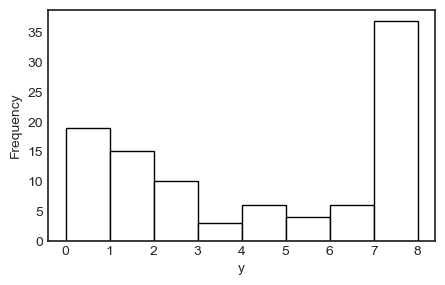

In [3]:
#d['y']のヒストグラム
plt.hist(d['y'], bins=8, color='white', edgecolor='black')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.show()

In [4]:
!pip install pymc
import pymc as pm
import arviz as az

In [5]:
with pm.Model() as model:
    beta = pm.Normal('beta', mu=0, sigma=100)
    s = pm.Uniform('s', lower=0, upper=10000)
    r = pm.Normal('r', mu=0, sigma=s, shape=len(d.y))
    y = pm.Binomial('y', n=8, p=pm.invlogit(beta + r), observed=d.y)

Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta, s, r]


Output()

Sampling 3 chains for 100 tune and 1_500 draw iterations (300 + 4_500 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.039,0.325,-0.596,0.645,0.010,0.007,1041.0,1708.0,1.0
s,3.025,0.365,2.355,3.667,0.011,0.008,1070.0,2388.0,1.0


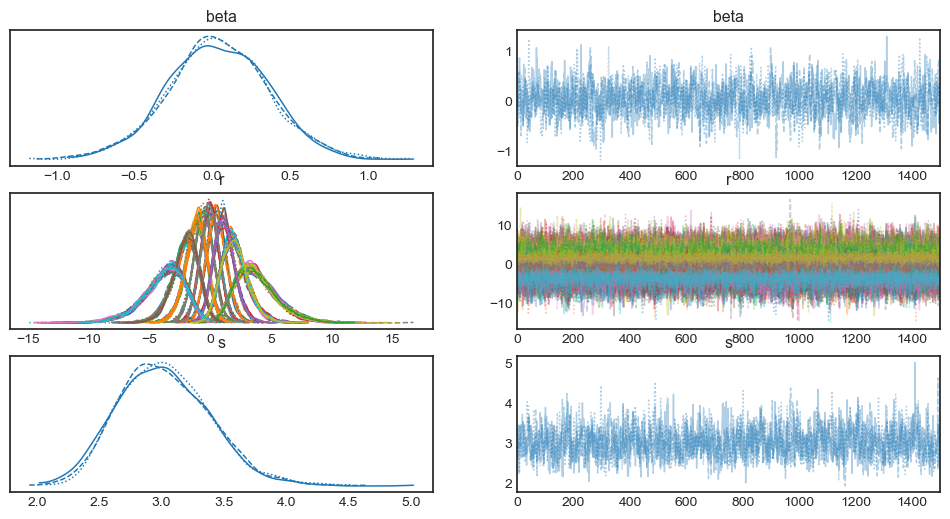

In [6]:
with model:
    trace = pm.sample(1500, step=pm.NUTS(), tune=100, cores=3, random_seed=0)

az.plot_trace(trace)
az.summary(trace).loc[['beta', 's']]

In [7]:
d = pd.read_csv('Ecology Data Analysis.csv')
#d.fが'C'のものは0、'T'のものは1に変換
d['f'] = d['f'].map({'C':0, 'T':1})
d.head()

,id,pot,f,y
0,1,A,0,6
1,2,A,0,3
2,3,A,0,19
3,4,A,0,5
4,5,A,0,0


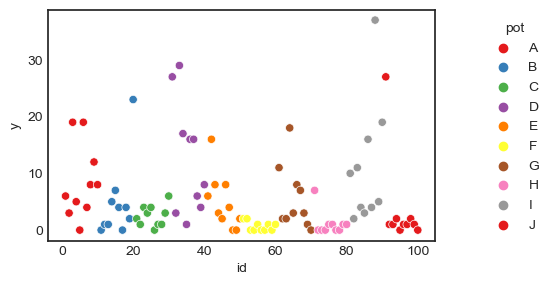

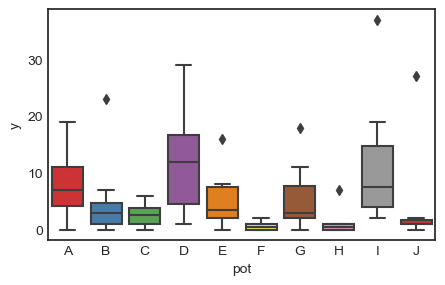

In [8]:
sns.scatterplot(data=d, x='id', y='y', hue='pot', palette='Set1')
plt.xlabel('id')
plt.ylabel('y')
plt.legend(title='pot', loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

sns.boxplot(data=d, x='pot', y='y', palette='Set1')
plt.xlabel('pot')
plt.ylabel('y')
plt.show()

In [9]:
with pm.Model() as model:
    beta1 = pm.Normal('beta1', mu=0, sigma=100)
    beta2 = pm.Normal('beta2', mu=0, sigma=100)
    s = pm.Uniform('s', lower=0, upper=10000)
    sp = pm.Uniform('sp', lower=0, upper=10000)
    r = pm.Normal('r', mu=0, sigma=s, shape=len(d.y))
    rp = pm.Normal('rp', mu=0, sigma=sp, shape=len(d.pot.unique()))
    d['pot_encoded'] = d.pot.astype('category').cat.codes
    y = pm.Poisson('y', mu=pm.math.exp(beta1 + beta2*d.f + r + rp[d.pot_encoded]), observed=d.y)

In [10]:
with model:
    trace = pm.sample(1500, step=pm.NUTS(), tune=100, cores=3, random_seed=0)

pm.summary(trace).loc[['beta1', 'beta2', 's', 'sp']]

Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta1, beta2, s, sp, r, rp]


Output()

Sampling 3 chains for 100 tune and 1_500 draw iterations (300 + 4_500 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta1,1.377,0.522,0.367,2.350,0.015,0.011,1328.0,1564.0,1.0
beta2,-0.853,0.761,-2.309,0.594,0.022,0.016,1221.0,1377.0,1.0
s,1.018,0.113,0.816,1.237,0.002,0.002,2172.0,2339.0,1.0
sp,1.048,0.384,0.456,1.738,0.009,0.006,2119.0,2386.0,1.0
